# Level E instructions:

### Some steps to get familiar with the data:

- Have a look at the rgb images in the folder "ARKitScenesData/47333473/47333473_frames/lowres_wide/" to get an impression of the scene that we are working with
- Run the notebook to see the complete pipeline: ground truth visualization, example detection, and full results

## Level E

The task is to generate 3D bounding boxes that mark the estimated location of objects in the environment.

Required to pass the level:
- Functional pipeline with visualization of the estimated 3D bounding boxes
- mIOU score > 0.15 of the bounding box estimates when comparing to ground-truth (For classes: "bed", "sofa", "chair", "table", "shelf")
- Understand and explain the code flow and steps required for the complete pipeline
- Show at least one detection of a non-ground-truth object (see last cell)

## 1. Dependencies and Imports


In [2]:
# Install dependencies
!pip install --upgrade pip
!pip install torch==2.4.0+cu121 torchvision==0.19.0+cu121 --index-url https://download.pytorch.org/whl/cu121
!pip install transformers==4.44.0 huggingface-hub==0.24.0 pillow numpy opencv-python open3d ipympl rerun-sdk[notebook]

Looking in indexes: https://download.pytorch.org/whl/cu121


In [3]:
# Import required libraries
import os
from typing import Dict, List, Tuple
import numpy as np
from PIL import Image
import torch

# Import lab utility functions
from lab_utils.data_utils import get_frame_list, load_camera_poses, validate_and_align_frame_data
from lab_utils.ground_truth import load_ground_truth_data
from lab_utils.tsdf_utils import build_tsdf_point_cloud
from lab_utils.viz_eval import visualize_3d_scene_bbox_results, evaluate_level_results
from lab_utils.model_loaders import load_owlv2_model
from lab_utils.level_specific_viz import visualize_level_e_example
from lab_utils.batch_processing_utils import process_frames_in_batches
from lab_utils.detection_utils import (
    detect_objects_in_frame, generate_3d_detections, merge_overlapping_detections, compute_3d_bbox_iou
)
from lab_utils.visualization_utils import visualize_2d_detections

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/jovyan/venv_lab2/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


## 2. Configuration


In [12]:
class Config:
    # Scene Configuration
    SCENE_ID = "47333473"
    BASE_PATH = f"ARKitScenesData/{SCENE_ID}/{SCENE_ID}_frames"
    RGB_PATH = os.path.join(BASE_PATH, "lowres_wide")
    DEPTH_PATH = os.path.join(BASE_PATH, "lowres_depth")
    INTRINSICS_PATH = os.path.join(BASE_PATH, "lowres_wide_intrinsics")
    TRAJ_FILE_PATH = os.path.join(BASE_PATH, "lowres_wide.traj")
    
    # Detection Classes
    OBJECT_CLASSES = ["bed", "chair", "sofa", "table", "shelf"]
    
    # Level E Configuration
    LEVEL_E_CONFIG = {
        'frame_skip': 3,
        'max_frames': 1000,
        'detection_threshold': 0.5,
        'owl_batch_size': 20,
        'merge_iou_threshold': 0.4, #change this one
        'min_detections_for_merge': 4,
        'example_viz_index': 47,
        'required_miou': 0.15
    }
    
    # TSDF Configuration
    TSDF_CONFIG = {
        'frame_skip': 3, 'depth_scale': 1000.0, 'depth_trunc': 7.0,
        'voxel_size': 0.04, 'batch_size': 20, 'max_frames': 1000,
        'volume_length': 30.0, 'resolution': 512,
    }

    # GT and Display Configuration
    GT_CONFIG = {
        'allowed_classes': None, 'mesh_downsample_points': 75000,
        'show_mesh': True, 'show_annotations': True
    }
    RERUN_WIDTH, RERUN_HEIGHT = 1200, 500

def validate_config(config: Config) -> None:
    """Validate and initialize configuration parameters."""
    config.GT_CONFIG['allowed_classes'] = config.OBJECT_CLASSES
    print(f"Configuration validated.")

# Create and validate config
config = Config()
validate_config(config)

Configuration validated.


## 3. Scene Understanding - Ground Truth Visualization

Let's start by visualizing the ground truth data to understand what we're working with:

In [13]:
# Load and visualize ground truth to understand the scene
print("Loading ground truth data to understand our scene...")

gt_annotations, gt_mesh = load_ground_truth_data(
    config.SCENE_ID, 
    config.BASE_PATH,
    config.GT_CONFIG
)

if gt_annotations:
    print(f"✓ Loaded {len(gt_annotations)} ground truth annotations")
    class_counts = {}
    for ann in gt_annotations:
        class_counts[ann['label']] = class_counts.get(ann['label'], 0) + 1
    print(f"Objects in scene: {class_counts}")

if gt_mesh:
    print(f"✓ Loaded ground truth mesh with {len(gt_mesh.points)} points")

# Visualize the ground truth scene
visualize_3d_scene_bbox_results(
    point_cloud=None,
    detections_3d=None,
    gt_annotations=gt_annotations,
    gt_mesh=gt_mesh,
    show_ground_truth=True,
    show_gt_mesh=True,
    show_object_pointclouds=False,
    title=f"Ground Truth Scene {config.SCENE_ID} - What We Want to Detect",
    config=config
)

print("👆 This shows the ground truth objects we want to detect!")

Loading ground truth data to understand our scene...
Loading ground truth annotations from: ARKitScenesData/47333473/47333473_frames/../47333473_3dod_annotation.json
Successfully processed 6 ground truth annotations
Loading ground truth mesh from: ARKitScenesData/47333473/47333473_frames/../47333473_3dod_mesh.ply
Loaded mesh with 75000 points
✓ Loaded 6 ground truth annotations
Objects in scene: {'bed': 1, 'shelf': 1, 'sofa': 2, 'table': 1, 'chair': 1}
✓ Loaded ground truth mesh with 75000 points
Visualizing: Ground Truth Scene 47333473 - What We Want to Detect


HTML(value='<div id="1cb60a5b-36c0-4c92-85e1-c50e2bddb609"><style onload="eval(atob(\'KGFzeW5jIGZ1bmN0aW9uICgp…

Viewer()

3D visualization complete
👆 This shows the ground truth objects we want to detect!


## 4. Execution Functions

These functions orchestrate the different parts of the pipeline:

In [14]:
def run_ground_truth_visualization(config: Config) -> None:
    """Execute ground truth visualization."""
    print("=" * 60)
    print("GROUND TRUTH VISUALIZATION")
    print("=" * 60)
    
    gt_annotations, gt_mesh = load_ground_truth_data(
        config.SCENE_ID, 
        config.BASE_PATH,
        config.GT_CONFIG
    )
    
    if gt_annotations:
        print(f"Loaded {len(gt_annotations)} ground truth annotations")
        class_counts = {}
        for ann in gt_annotations:
            class_counts[ann['label']] = class_counts.get(ann['label'], 0) + 1
        print(f"GT objects by class: {class_counts}")
    
    if gt_mesh:
        print(f"Loaded ground truth mesh with {len(gt_mesh.points)} points")
    
    visualize_3d_scene_bbox_results(
        point_cloud=None,
        detections_3d=None,
        gt_annotations=gt_annotations,
        gt_mesh=gt_mesh,
        show_ground_truth=True,
        show_gt_mesh=True,
        show_object_pointclouds=False,
        title=f"Ground Truth Only - Scene {config.SCENE_ID}",
        config=config
    )
    
    print("Ground truth visualization complete!")


def run_example_visualization(config: Config) -> Dict:
    """Execute example visualization."""
    print("\n" + "=" * 60)
    print("EXAMPLE VISUALIZATION")
    print("=" * 60)
    
    example_results = visualize_level_e_example(
        config, 
        frame_index=config.LEVEL_E_CONFIG['example_viz_index'],
        show_depth_analysis=True
    )
    
    print("Example visualization complete!")
    return example_results


def run_full_pipeline(config: Config) -> Dict:
    """Execute the complete 3D scene analysis pipeline."""
    print("\n" + "=" * 60)
    print("FULL PIPELINE EXECUTION")
    print("=" * 60)
    
    processor, model, device = load_owlv2_model()
    camera_poses = load_camera_poses(config.TRAJ_FILE_PATH)
    frames_metadata = get_frame_list(config.RGB_PATH, config.LEVEL_E_CONFIG['frame_skip'])
    aligned_frames = validate_and_align_frame_data(
        frames_metadata, camera_poses, config.RGB_PATH, 
        config.DEPTH_PATH, config.INTRINSICS_PATH, timestamp_tolerance=0.1
    )
    
    if not aligned_frames:
        print("ERROR: No aligned frames found! Check data paths.")
        return {'detections_3d': [], 'frame_results': {}, 'statistics': {}}
    
    frames_for_detection = aligned_frames[:config.LEVEL_E_CONFIG['max_frames']]
    raw_detections_3d, frame_results, detection_stats = process_frames_in_batches(
        frames_for_detection, config, processor, model, device
    )
    
    merged_detections = merge_overlapping_detections(
        raw_detections_3d,
        iou_threshold=config.LEVEL_E_CONFIG['merge_iou_threshold'],
        min_detections_for_merge=config.LEVEL_E_CONFIG['min_detections_for_merge']
    ) if raw_detections_3d else []
    
    print(f"Pipeline: {len(frames_for_detection)} frames → {len(raw_detections_3d)} raw → {len(merged_detections)} merged")
    
    tsdf_point_cloud = build_tsdf_point_cloud(config, max_frames_for_mapping=596, use_cached=True)
    gt_annotations, gt_mesh = load_ground_truth_data(config.SCENE_ID, config.BASE_PATH, config.GT_CONFIG)
    eval_results = evaluate_level_results(merged_detections, gt_annotations, "Level E (OwlV2 Only)", required_miou=config.LEVEL_E_CONFIG['required_miou'])
    
    print(f"Results: {'✓ PASSED' if eval_results['passed'] else '✗ FAILED'} | "
          f"mIoU: {eval_results['mean_iou']:.3f} | Detections: {eval_results['num_detections']}")
    
    if merged_detections or raw_detections_3d or tsdf_point_cloud:
        visualize_3d_scene_bbox_results(
            point_cloud=tsdf_point_cloud, detections_3d=merged_detections,
            raw_detections_3d=raw_detections_3d, gt_annotations=gt_annotations,
            gt_mesh=None, show_ground_truth=True, show_gt_mesh=False,
            show_object_pointclouds=False, show_raw_detections=True,
            title=f"Level E: Raw + Merged Detections - Scene {config.SCENE_ID}",
            config=config
        )
    
    print("Full pipeline complete!")
    return {
        'detections_3d': merged_detections,
        'raw_detections_3d': raw_detections_3d,
        'frame_results': frame_results,
        'statistics': {
            **detection_stats,
            'total_3d_detections_merged': len(merged_detections),
            'detection_classes': list(detection_stats['detection_classes']),
            'alignment_success_rate': len(aligned_frames) / len(frames_metadata) * 100 if frames_metadata else 0,
            'merge_ratio': len(merged_detections) / len(raw_detections_3d) if raw_detections_3d else 0
        },
        'evaluation': eval_results
    }

## 5. 2D Detection with OwlV2 Model

Complete the TODOs in the functions below and run the visualization to understand the object detector.

In [15]:
def process_owlv2_outputs(outputs, processor, target_sizes, text_queries, threshold=0.1):
    """Process raw OwlV2 model outputs into detection format."""
    results = processor.post_process_object_detection(
        outputs=outputs, target_sizes=target_sizes, threshold=threshold
    )[0]

    print("results: ", results)
    
    # TODO: Extract results, move to cpu and convert to numpy arrays
    boxes = results["boxes"].cpu().numpy()
    scores = results["scores"].cpu().numpy()
    labels = results["labels"].cpu().numpy()
    
    # TODO: Create detection list
    detections = []
    for box, score, label in zip(boxes, scores, labels):
        detections.append({
            'bbox': box.tolist(),
            'score': float(score), 
            'label': text_queries[label],
            'label_id': int(label)
        })
    
    return detections

Visualize the detector:

Running example detection on a single frame...
LEVEL E EXAMPLE VISUALIZATION
Demonstrating OwlV2 object detection on frame 47
Target classes: ['bed', 'chair', 'sofa', 'table', 'shelf']

1. Loading OwlV2 model...
Loading OWLv2 model...
Model loaded on device: cuda

2. Loading frame data...
Loaded 540 camera poses
Selected 180 frames from 540 total
Validating and aligning 180 frames...
Aligned 180 frames (skipped 0)
Selected frame: 47333473_58542.353.png

3. Running OwlV2 object detection...
Found 1 detections above threshold 0.5
  1. sofa: 0.576 at [0, 61, 123, 192]

4. Visualizing 2D detection results...


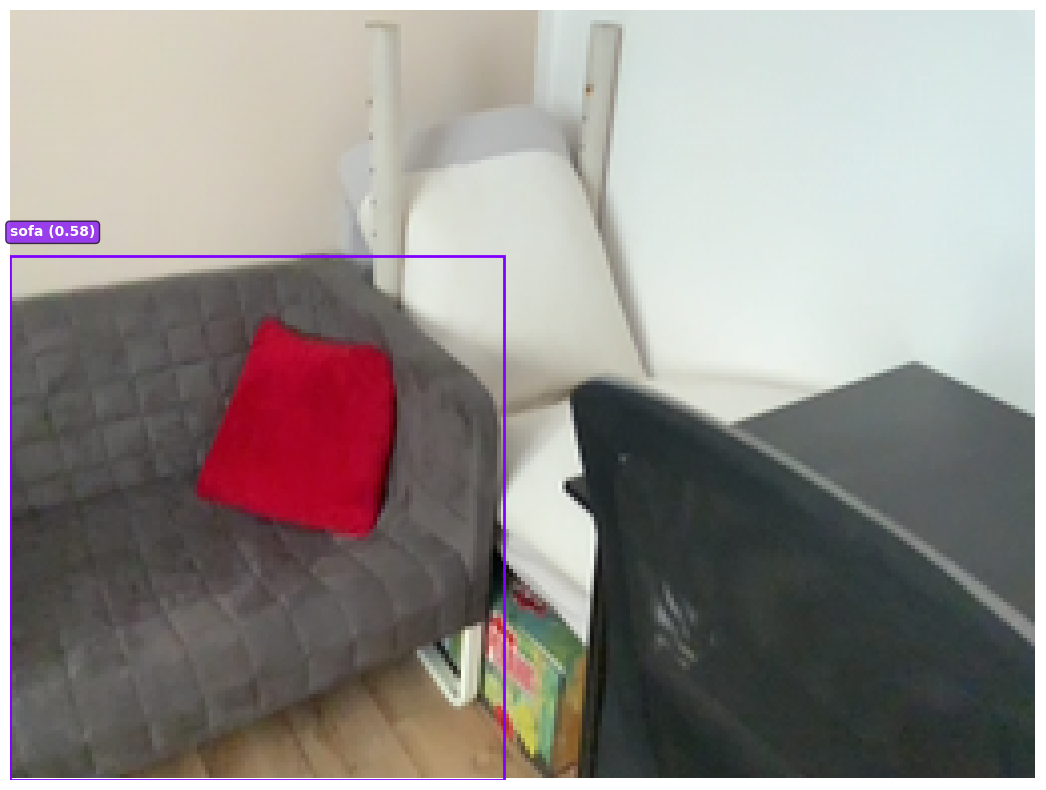


EXAMPLE VISUALIZATION SUMMARY
Frame: 47333473_58542.353.png
Detections: 1
Classes found: ['sofa']


In [16]:
# Run example visualization to see detection process on a single frame
print("Running example detection on a single frame...")

example_results = visualize_level_e_example(
    config, 
    frame_index=config.LEVEL_E_CONFIG['example_viz_index'],
    show_depth_analysis=True
)

## 6. 3D Processing Implementation
Implement the TODOs below


In [17]:
# TODO 1: Camera Projection
def project_pixel_to_3d(center_pixel: List[float], depth: float, camera_intrinsics: np.ndarray) -> List[float]:
    """Project a single pixel + depth to 3D coordinates."""
    # TODO: Extract camera parameters and apply pinhole model
    fx, fy = camera_intrinsics[0,0], camera_intrinsics[1,1]  
    cx, cy = camera_intrinsics[0,2], camera_intrinsics[1,2]
    center_u, center_v = center_pixel
    x_3d = (center_u - cx) * depth / fx  # YOUR CODE HERE
    y_3d = (center_v - cy) * depth/ fy
    z_3d = depth
    
    return [float(x_3d), float(y_3d), float(z_3d)]

# TODO 2: Find Overlapping Detections (mostly provided, fill in the TODO parts)
def find_overlapping_detections(detections_3d: List[Dict], class_name: str, iou_threshold: float = 0.4) -> List[List[int]]:
    """Find which detections of same class overlap significantly."""
    # Filter by class
    class_detections = [i for i, d in enumerate(detections_3d) if d['label'] == class_name]
    
    overlapping_pairs = []
    
    # Check all pairs
    for i in range(len(class_detections)):
        for j in range(i + 1, len(class_detections)):
            idx1, idx2 = class_detections[i], class_detections[j]
            
            # TODO: Compute IoU between the two 3D bounding boxes (hint: check if you can use a function defined above)
            bbox1 = detections_3d[idx1]["bbox_3d_world"]
            bbox2 = detections_3d[idx2]["bbox_3d_world"]
            iou = compute_3d_bbox_iou(bbox1, bbox2)
            
            # TODO: Check if IoU exceeds threshold and append to overlapping_pairs
            if iou >= iou_threshold:
                overlapping_pairs.append([idx1, idx2])
    
    return overlapping_pairs  # Returns list of overlapping pairs of indices

# PROVIDED: Merge Detection Cluster
def merge_detection_cluster(detection_indices: List[int], all_detections: List[Dict]) -> Dict:
    """Merge a cluster of overlapping detections into one."""
    # Extract detections
    cluster_detections = [all_detections[i] for i in detection_indices]
    
    # Get all corners and scores
    all_corners = [det['bbox_3d_world'] for det in cluster_detections]
    all_scores = [det['score'] for det in cluster_detections]
    
    # Average the corners and scores
    merged_corners = np.mean(all_corners, axis=0)
    avg_score = np.mean(all_scores)
    
    # Get class name
    class_name = cluster_detections[0]['label']
    
    # Calculate center from averaged corners
    corners_array = np.array(merged_corners)
    center = np.mean(corners_array, axis=0)
    
    return {
        'label': class_name,
        'score': float(avg_score),
        'bbox_3d_world': merged_corners.tolist(),
        'center_3d_world': center.tolist(),
        'merge_info': {
            'num_detections_merged': len(detection_indices),
            'original_confidences': all_scores
        }
    }

## 7. Full Pipeline Execution

Now let's run the complete pipeline across all frames. You can enable and disable visualization of different things (GT, raw detections, merged, ...) in the viewer.

In [19]:
# Execute the complete 3D object detection pipeline
print("Running full pipeline across all frames...")

pipeline_results = run_full_pipeline(config)

Running full pipeline across all frames...

FULL PIPELINE EXECUTION
Loading OWLv2 model...
Model loaded on device: cuda
Loaded 540 camera poses
Selected 180 frames from 540 total
Validating and aligning 180 frames...
Aligned 180 frames (skipped 0)
Processing 180 frames in 9 batches of 20...


Batch processing complete: 43/180 frames successful
Merging overlapping detections...
Merged 47 detections into 6 objects
Pipeline: 180 frames → 47 raw → 6 merged
Using cached TSDF point cloud
Loading ground truth annotations from: ARKitScenesData/47333473/47333473_frames/../47333473_3dod_annotation.json
Successfully processed 6 ground truth annotations
Loading ground truth mesh from: ARKitScenesData/47333473/47333473_frames/../47333473_3dod_mesh.ply
Loaded mesh with 75000 points

LEVEL E (OWLV2 ONLY) EVALUATION
Detections: 6
Ground Truth: 6
Mean IoU: 0.151
Median IoU: 0.148
GT Matched (IoU>0.1): 4/6
✓ PASSED: mIoU 0.151 > 0.15 requirement
Results: ✓ PASSED | mIoU: 0.151 | Detections: 6
Visualizing: Level E: Raw + Merged Detections - Scene 47333473


HTML(value='<div id="6cd9ba3c-66c5-4675-a5b7-32b7138f9a2a"><style onload="eval(atob(\'KGFzeW5jIGZ1bmN0aW9uICgp…

Viewer()

3D visualization complete
Full pipeline complete!


## 8. Open Vocabulary Exploration

In [20]:
# First complete the main pipeline above, then set RUN_EXPLORATION = True to experiment

RUN_EXPLORATION = True  # TODO: Set to True when ready to explore

EXPLORATION_CLASSES = [
    "bed", "chair", "sofa", "table", "shelf",  # Keep original classes
    # TODO: Add 2-3 additional objects you want to find:
    "plant",
    "ball"
]

if RUN_EXPLORATION:
    if len(EXPLORATION_CLASSES) > 5:
        print(f"Exploring: {EXPLORATION_CLASSES}")
        
        # Create new config with exploration classes
        exploration_config = Config()
        exploration_config.OBJECT_CLASSES = EXPLORATION_CLASSES
        
        # Run pipeline
        results = run_full_pipeline(exploration_config)
        
        # Show what was found
        detections = results.get('detections_3d', [])
        print(f"Found {len(detections)} objects: {[d['label'] for d in detections]}")
    else:
        print("Add some new objects to EXPLORATION_CLASSES to start exploring!")
else:
    print("Set RUN_EXPLORATION = True to try detecting different objects")

Exploring: ['bed', 'chair', 'sofa', 'table', 'shelf', 'plant', 'ball']

FULL PIPELINE EXECUTION
Loading OWLv2 model...
Model loaded on device: cuda
Loaded 540 camera poses
Selected 180 frames from 540 total
Validating and aligning 180 frames...
Aligned 180 frames (skipped 0)
Processing 180 frames in 9 batches of 20...


Batch processing complete: 63/180 frames successful
Merging overlapping detections...
Merged 82 detections into 10 objects
Pipeline: 180 frames → 82 raw → 10 merged
Using cached TSDF point cloud
Loading ground truth annotations from: ARKitScenesData/47333473/47333473_frames/../47333473_3dod_annotation.json
Successfully processed 6 ground truth annotations
Loading ground truth mesh from: ARKitScenesData/47333473/47333473_frames/../47333473_3dod_mesh.ply
Loaded mesh with 75000 points

LEVEL E (OWLV2 ONLY) EVALUATION
Detections: 10
Ground Truth: 6
Mean IoU: 0.151
Median IoU: 0.148
GT Matched (IoU>0.1): 4/6
✓ PASSED: mIoU 0.151 > 0.15 requirement
Results: ✓ PASSED | mIoU: 0.151 | Detections: 10
Visualizing: Level E: Raw + Merged Detections - Scene 47333473


HTML(value='<div id="aef4b008-d1b2-47bb-ae2a-9da63b7769fb"><style onload="eval(atob(\'KGFzeW5jIGZ1bmN0aW9uICgp…

Viewer()

3D visualization complete
Full pipeline complete!
Found 10 objects: ['bed', 'sofa', 'table', 'shelf', 'shelf', 'shelf', 'ball', 'ball', 'plant', 'plant']
